# Lego Tile User Workflow

This notebook demonstrates the complete workflow for interacting with the Lego tile services. It shows how to:
1. Authenticate using OIDC
2. Claim a tile to build
3. Release a tile (if unable to complete)
4. Commit a tile (when completed)

**Note**: For web developers implementing this workflow in React, see the [auth_example.jsx](auth_example.jsx) file for a complete authentication implementation including PKCE flow and token renewal.

## Important Notes

- **Tile Ownership**: Each tile can only be claimed by one user at a time
- **User Verification**: Only the user who claimed a tile can release or commit it
- **State Management**: Tiles progress through states: available → claimed → released/submitted
- **Grid Dimensions**: 26x27 tiles at zoom level 7

## Setup
First, we'll import the required libraries and set up our connection.

In [1]:
import openeo
import requests

# Backend URL - adjust this to your deployment
base_url = "http://127.0.0.1:8081/"

# Connect to the back-end
connection = openeo.connect(base_url)

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8081): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7125c49ee950>: Failed to establish a new connection: [Errno 111] Connection refused'))

## Authentication

Authentication is required for claiming, releasing, and committing tiles. The system uses OpenID Connect (OIDC) with PKCE (Proof Key for Code Exchange) for secure authentication.

The system uses the Copernicus Data Space Ecosystem (CDSE) identity provider:
```
https://identity.dataspace.copernicus.eu/auth/realms/CDSE/.well-known/openid-configuration
```

When you run the authentication cell, it will open a browser window for you to log in with your OIDC provider.

In [ ]:
# Authenticate using OIDC
connection.authenticate_oidc()

# Store the token for later use
token = connection.auth.bearer

Authenticated using refresh token.


## Claiming a Tile

When claiming a tile, the service will:
1. Assign you an available tile from the grid
2. Generate building instructions for that tile
3. Lock the tile to prevent others from claiming it

The response will be a PNG image containing the building instructions.

**Note**: If you already have a claimed tile, the service will return that tile's instructions instead of assigning a new one.

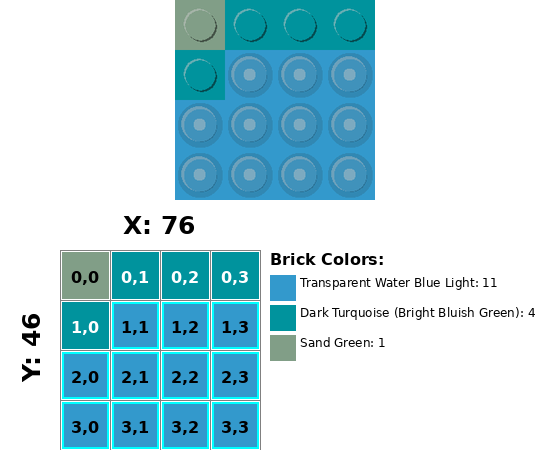

In [ ]:
claim_service_id = "12846e5b-6769-401b-877d-d8727a92ccf8"
zoom_level = 7

# Call the claim service
# Note: x=0, y=0 are placeholder values - the service will assign an available tile
response = requests.get(
    f"{base_url}/services/xyz/{claim_service_id}/tiles/{zoom_level}/0/0",
    headers={"Authorization": f"Bearer {token}"},
)

# Display the tile instructions
if response.status_code == 200:
    from PIL import Image
    from IPython.display import display
    from io import BytesIO

    img = Image.open(BytesIO(response.content))
    display(img)
else:
    print("Error:", response.status_code)
    print(response.text)
    
    # Common error cases:
    # 401 - Not authenticated
    # 403 - Not authorized
    # 409 - No tiles available

## Same in JSON

The following code snippet shows how to claim a tile and get the building instructions in JSON format. The response will include the tile ID, coordinates, and the building instructions in JSON format.

In [ ]:
claim_service_json_id = "e17e1efc-fa76-43f3-a86c-c615c1810411"
zoom_level = 7

# Call the claim service
# Note: x=0, y=0 are placeholder values - the service will assign an available tile
response = requests.get(
    f"{base_url}/services/xyz/{claim_service_json_id}/tiles/{zoom_level}/0/0",
    headers={"Authorization": f"Bearer {token}"},
)

# Display the tile instructions
if response.status_code == 200:
    print("Tile instructions: " + response.text)
else:
    print("Error:", response.status_code)
    print(response.text)
    
    # Common error cases:
    # 401 - Not authenticated
    # 403 - Not authorized
    # 409 - No tiles available

Tile instructions: {"instruction_metadata": {"total_bricks": 16, "color_counts": {"Sand Green": 1, "Dark Turquoise (Bright Bluish Green)": 4, "Transparent Water Blue Light": 11}, "x_position": 76, "y_position": 46}, "brick_info": {"pixels": {"0_0": {"position": [0, 0], "color_name": "Sand Green", "is_water": false, "rgb": [129, 158, 135]}, "0_1": {"position": [0, 1], "color_name": "Dark Turquoise (Bright Bluish Green)", "is_water": false, "rgb": [0, 147, 157]}, "0_2": {"position": [0, 2], "color_name": "Dark Turquoise (Bright Bluish Green)", "is_water": false, "rgb": [0, 147, 157]}, "0_3": {"position": [0, 3], "color_name": "Dark Turquoise (Bright Bluish Green)", "is_water": false, "rgb": [0, 147, 157]}, "1_0": {"position": [1, 0], "color_name": "Dark Turquoise (Bright Bluish Green)", "is_water": false, "rgb": [0, 147, 157]}, "1_1": {"position": [1, 1], "color_name": "Transparent Water Blue Light", "is_water": true, "rgb": [51, 153, 204]}, "1_2": {"position": [1, 2], "color_name": "Tra

## Releasing a Tile

If you are unable to complete your assigned tile, you can release it back to the pool for others to claim.
This should be done if you:
- Don't have the required brick colors
- Don't have time to complete the build
- Encounter any issues preventing completion

**Important**: 
- You can only release tiles that you have claimed
- You cannot release a tile that has already been submitted
- Released tiles become available for other users to claim

In [ ]:
release_service_id = "2818bbc0-8aee-4acf-a0b3-bba94506d172"

# Call the release service
# Note: x=0, y=0 are placeholder values - the service will release your assigned tile
response = requests.get(
    f"{base_url}/services/xyz/{release_service_id}/tiles/{zoom_level}/0/0",
    headers={"Authorization": f"Bearer {token}"},
)

if response.status_code == 200:
    print("Tile successfully released")
    print(response.text)
else:
    print("Error:", response.status_code)
    print(response.text)
    
    # Common error cases:
    # 401 - Not authenticated
    # 403 - Not authorized
    # 404 - No tile assigned to release
    # 409 - Cannot release (e.g., tile already submitted)

Tile successfully released
{'x': '59', 'y': '30', 'z': '7', 'stage': 'released'}


## Committing a Tile

Once you have completed building your tile, you should commit it to mark it as finished.
This will:
1. Permanently mark the tile as completed
2. Prevent the tile from being released or reassigned
3. Update the overall map progress

**Important Requirements**:
- You must be the user who claimed the tile
- The tile must be in a 'claimed' state (not released or already submitted)
- You should only commit after:
  - Fully completing the build according to instructions
  - Verifying all colors and placements
  - Attaching the tile to the main map in the correct position

**Warning**: Committing a tile is permanent and cannot be undone!

In [ ]:
commit_service_id = "1c15880d-a302-4fbd-85bd-6cea3c746d8a"

# Call the commit service
# Note: x=0, y=0 are placeholder values - the service will commit your assigned tile
response = requests.get(
    f"{base_url}/services/xyz/{commit_service_id}/tiles/{zoom_level}/0/0",
    headers={"Authorization": f"Bearer {token}"},
)

if response.status_code == 200:
    print("Tile successfully committed")
    print(response.text)
else:
    print("Error:", response.status_code)
    print(response.text)
    
    # Common error cases:
    # 401 - Not authenticated
    # 403 - Not authorized
    # 404 - No tile assigned to commit
    # 409 - Cannot commit (e.g., tile already submitted or released)

Error: 500
{"code":"ServerError","message":"No tile assigned to user ebd537e1-3024-45c4-b85a-57ece3dee762"}


## Error Handling

The services use standard HTTP status codes to indicate success or failure:

- **200**: Success
- **401**: Not authenticated (missing or invalid token)
- **403**: Not authorized (insufficient permissions)
- **404**: Resource not found (e.g., no tile assigned)
- **409**: Conflict (e.g., no tiles available, tile already claimed)

When an error occurs, the response will include a detailed message explaining the issue.